<a href="https://colab.research.google.com/github/ykato27/Image-Classification/blob/main/CNN_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

## Fashion-MNISTとは
- Fashion-MNIST は、オンラインショップ Zalando 上の衣類の画像から作成されたデータセット
- 6万枚の学習データ、1万枚のテストデータで構成されている
- 各サンプルは大きさが 28×28 のグレースケール画像で、10クラスのいずれかがラベル付けされている

## Fashion-MNIST読み込み
- 引数
    - root: データセットを保存するディレクトリのパスを指定します。
    - train: True を指定した場合は学習データ、False を指定した場合はテストデータをダウンロードします。
    - transform: 画像に対して行う前処理を指定します。今回は、transforms.ToTensor のみを指定しました。 この Transformer は、画素値を範囲が [0, 255] の uint8 型から範囲が [0, 1] の float32 型にし、Pytorch で扱う Tensor に変換を行います。
    - download: True を指定した場合は、データセットがローカルにない場合は、ネットからダウンロードします。

In [2]:
data_transform = transforms.ToTensor()

# 学習データを読み込む DataLoader を作成する。
train_dataset = datasets.FashionMNIST(
    root="datasets", train=True, transform=data_transform, download=True
)
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

# テストデータを読み込む DataLoader を作成する。
test_dataset = datasets.FashionMNIST(
    root="datasets", train=False, transform=data_transform, download=True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=True
)


Extracting datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to datasets/FashionMNIST/raw




Extracting datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw




Extracting datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to datasets/FashionMNIST/raw




Extracting datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Fashion-MNISTの中身
- FashionMNIST.classes (list): クラス名一覧
- FashionMNIST.class_to_idx (dict): クラス名、値がクラス ID の辞書
- FashionMNIST.data (Tensor): 画像一覧
- FashionMNIST.targets (Tensor): ラベル一覧

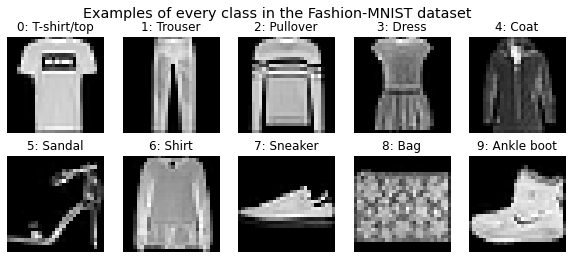

In [3]:
# 各クラスのラベルを持つサンプルを1つずつ取得する。
class_ids, sample_indices = np.unique(train_dataset.targets, return_index=True)

fig = plt.figure(figsize=(10, 4))
fig.suptitle(
    "Examples of every class in the Fashion-MNIST dataset", fontsize="x-large"
)

for i in class_ids:
    img = train_dataset.data[sample_indices[i]]
    class_name = train_dataset.classes[i]

    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title(f"{i}: {class_name}")
    ax.set_axis_off()
    ax.imshow(img, cmap="gray")

plt.show()

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        return x

In [5]:
nll_loss = nn.NLLLoss()

In [6]:
# 計算を実行するデバイスを選択する。
# CUDA が利用可能な場合は、GPU、そうでない場合は CPU を選択する。
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルを計算を実行するデバイスに転送する。
model = Net().to(device)

In [7]:
# Optimizer を作成する。
optim = torch.optim.Adam(model.parameters())

In [8]:
def train(model, device, data_loader, optim):
    """
    1エポック分の学習を行う。
        :param model: モデル
        :param device: デバイス
        :param data_loader: Data Loader
        :param optim: Optimizer
    """
    # モデルを学習モードに設定する。
    model.train()

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        # データ及びラベルを計算を実行するデバイスに転送する。
        data, target = data.to(device), target.to(device)

        # 順伝搬を行う。
        output = model(data)

        # 損失関数の値を計算する。
        loss = nll_loss(output, target)
        total_loss += float(loss)

        # 逆伝搬を行う。
        optim.zero_grad()
        loss.backward()

        # パラメータを更新する。
        optim.step()

        # 確率の最も高いクラスを予測ラベルとする。
        pred_target = output.argmax(dim=1)

        # 正答数を計算する。
        total_correct += int((pred_target == target).sum())

    # 損失関数の値の平均及び精度を計算する。
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / len(data_loader.dataset)

    return avg_loss, accuracy

In [9]:
def test(model, device, data_loader):
    """
    テストデータに対する損失の平均及び精度を計算する。
        :param model: モデル
        :param device: デバイス
        :param data_loader: Data Loader
    """
    # モデルをテストモードに設定する。
    model.eval()

    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        for data, target in data_loader:
            # データ及びラベルを計算を実行するデバイスに転送する。
            data, target = data.to(device), target.to(device)

            # 順伝搬する。
            output = model(data)

            # 損失を計算する。
            loss = nll_loss(output, target)
            total_loss += float(loss)

            # 確率の最も高いクラスを予測ラベルとする。
            pred_target = output.argmax(dim=1)

            # 正答数を計算する。
            total_correct += int((pred_target == target).sum())

    # 損失の平均及び精度を計算する。
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / len(data_loader.dataset)

    return avg_loss, accuracy

In [10]:
n_epochs = 50

history = defaultdict(list)
for epoch in range(n_epochs):
    # 1エポック分、学習する。
    train_loss, train_accuracy = train(model, device, train_data_loader, optim)
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)

    # 評価する。
    test_loss, test_accuracy = test(model, device, test_data_loader)
    history["test_loss"].append(test_loss)
    history["test_accuracy"].append(test_accuracy)

    print(
        f"epoch {epoch + 1} "
        f"[train] loss: {train_loss:.6f}, accuracy: {train_accuracy:.0%} "
        f"[test] loss: {test_loss:.6f}, accuracy: {test_accuracy:.0%}"
    )

epoch 1 [train] loss: 0.009423, accuracy: 78% [test] loss: 0.006133, accuracy: 85%
epoch 2 [train] loss: 0.006516, accuracy: 85% [test] loss: 0.005272, accuracy: 87%
epoch 3 [train] loss: 0.005651, accuracy: 87% [test] loss: 0.004678, accuracy: 89%
epoch 4 [train] loss: 0.005194, accuracy: 88% [test] loss: 0.004339, accuracy: 90%
epoch 5 [train] loss: 0.004902, accuracy: 89% [test] loss: 0.004208, accuracy: 90%
epoch 6 [train] loss: 0.004617, accuracy: 89% [test] loss: 0.004005, accuracy: 91%
epoch 7 [train] loss: 0.004398, accuracy: 90% [test] loss: 0.003875, accuracy: 91%
epoch 8 [train] loss: 0.004216, accuracy: 90% [test] loss: 0.003717, accuracy: 91%
epoch 9 [train] loss: 0.004073, accuracy: 91% [test] loss: 0.003745, accuracy: 91%
epoch 10 [train] loss: 0.003966, accuracy: 91% [test] loss: 0.003716, accuracy: 91%
epoch 11 [train] loss: 0.003895, accuracy: 91% [test] loss: 0.003515, accuracy: 92%
epoch 12 [train] loss: 0.003746, accuracy: 91% [test] loss: 0.003521, accuracy: 92%
e

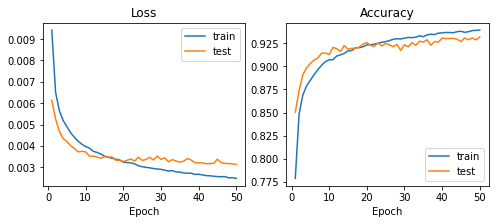

In [11]:
epochs = np.arange(1, n_epochs + 1)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 3))

# 損失の推移
ax1.set_title("Loss")
ax1.plot(epochs, history["train_loss"], label="train")
ax1.plot(epochs, history["test_loss"], label="test")
ax1.set_xlabel("Epoch")
ax1.legend()

# 精度の推移
ax2.set_title("Accuracy")
ax2.plot(epochs, history["train_accuracy"], label="train")
ax2.plot(epochs, history["test_accuracy"], label="test")
ax2.set_xlabel("Epoch")
ax2.legend()

plt.show()